<a href="https://colab.research.google.com/github/MohamedElWaghf/Projet-Long/blob/master/ResNet50_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from keras.utils.np_utils import to_categorical
import pandas as pd
import numpy as np
import random
import sys
import warnings 
import matplotlib.pyplot as plt
%matplotlib inline 
from keras import layers
from keras import models
from keras import optimizers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
import cv2
from keras.regularizers import l2
from keras.layers import Input
import keras
from keras.preprocessing import image

In [3]:
!pip install keras_applications
!pip install git+https://github.com/rcmalli/keras-vggface.git

     |████████████████████████████████| 51kB 4.4MB/s 
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-hzspa41v
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-hzspa41v
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp37-none-any.whl size=8312 sha256=d799387ea87e113eceabac353aa1f4878403f8478e8a048794876b51692f4173
  Stored in directory: /tmp/pip-ephem-wheel-cache-mn8kcej7/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [4]:
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

In [5]:
data_path ='/content/drive/MyDrive/fer20131.csv'
data=pd.read_csv(data_path)

In [6]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
data.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [8]:
train_data = data[data.Usage=='Training']
val_data=data[data.Usage=='PublicTest']
test_data = data[data.Usage=='PrivateTest']

In [9]:
x_train = list(train_data.pixels.values.reshape(-1,1))
x_val = list(val_data.pixels.values.reshape(-1,1))
x_test  = list(test_data.pixels.values.reshape(-1,1))

for i,item in enumerate(x_train):
    x_train[i] = np.fromstring(item[0],sep=' ').reshape(48,48,1)

for i,item in enumerate(x_val):
    x_val[i] = np.fromstring(item[0],sep=' ').reshape(48,48,1)


for i,item in enumerate(x_test):
    x_test[i] = np.fromstring(item[0],sep=' ').reshape(48,48,1)
    
x_train = np.vstack(x_train).reshape(-1,48,48,1)
x_test = np.vstack(x_test).reshape(-1,48,48,1)
x_val = np.vstack(x_val).reshape(-1,48,48,1)

In [10]:
y_train = to_categorical(train_data.emotion.values,num_classes=7)
y_test  = to_categorical(test_data.emotion.values ,num_classes=7)
y_val  = to_categorical(val_data.emotion.values ,num_classes=7)

In [11]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(28709, 48, 48, 1)
(3589, 48, 48, 1)
(3589, 48, 48, 1)


In [12]:
y_train.shape

(28709, 7)

In [13]:
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Sad", 5: "Surprised", 6: "Neutral"}

In [14]:
len_labels={}
for label in list(data.emotion.unique()):
  inter_data=data[data.emotion==label]
  inter=len(inter_data.emotion)
  len_labels[emotion_dict[label]]=inter

In [15]:
data=pd.DataFrame({'labels':len_labels.keys(),'number of samples':len_labels.values()})

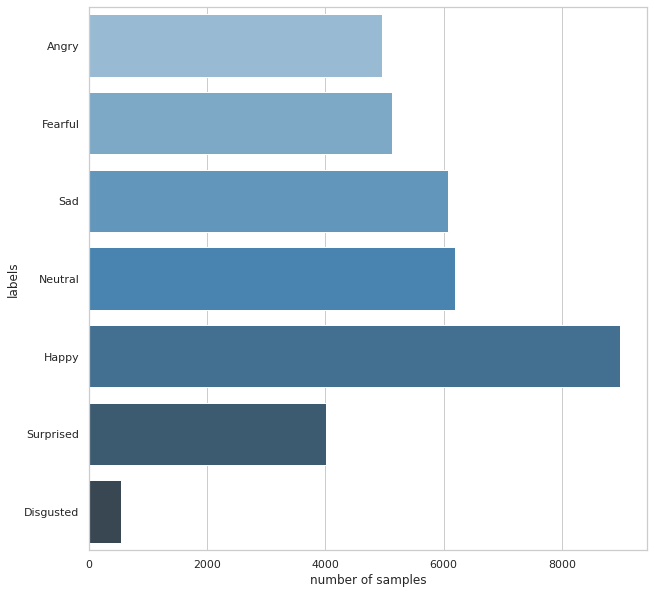

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,10))
sns.set_theme(style="whitegrid")

tips = sns.load_dataset("tips")

ax = sns.barplot(x='number of samples', y='labels',data=data,palette="Blues_d")

In [17]:
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [18]:
#from mxnet import image

In [19]:
from copy import deepcopy as copy

def smooth_labels(y, smooth_factor):
    '''Convert a matrix of one-hot row-vector labels into smoothed versions.

    # Arguments
        y: matrix of one-hot row-vector labels to be smoothed
        smooth_factor: label smoothing factor (between 0 and 1)

    # Returns
        A matrix of smoothed labels.
    '''
    assert len(y.shape) == 2, 'input should be a batch of one-hot-encoded data'
    y2 = copy(y)
    if 0 <= smooth_factor <= 1:
        # label smoothing ref: https://www.robots.ox.ac.uk/~vgg/rg/papers/reinception.pdf
        y2 *= 1 - smooth_factor
        y2 += smooth_factor / y.shape[1]
    else:
        raise Exception(
            'Invalid label smoothing factor: ' + str(smooth_factor))
    return y2

In [20]:
from keras.utils import Sequence
from keras.utils import to_categorical
import cv2
from math import floor

class data_sequence(Sequence):
    '''
      yield sequence of data
      features -- list of features
      labels -- list of labels
      target_channels {int} -- 1 (gray) or 3(RGB)
    '''
    def __init__(self, features, labels, batch_size=128, target_dim=(224,224), 
                 n_classes=7, shuffle=True, smooth=0.3):
        'Initialization'
        assert len(features)==len(labels), 'number of feature and labels not consistent'
        self.features = features
        self.labels = labels
        self.batch_size = batch_size
        self.target_dim = target_dim
        self.target_channels = 3
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.smooth = smooth
        self.sample_count = len(labels)
        self.indexes = np.arange(self.sample_count)
        self.on_epoch_end()
#         self.verbose = verbose

    def __len__(self):
        'Denotes the number of batches per epoch'
        return floor(self.sample_count / self.batch_size)

    def __gray2RGB__(self,x):
      if len(x.shape)==2:
        return np.stack((x,x,x),-1)
      else:
        assert len(x.shape)==3
        if len(x[0,0,:]) == 1:
          return np.stack((x[:,:,0],x[:,:,0],x[:,:,0]),-1)
        else:
          assert len(x[0,0,:])==self.target_channels
      return x


    def __getitem__(self, idx):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        X = np.empty((self.batch_size, *self.target_dim, self.target_channels))
        Y = np.empty((self.batch_size, self.n_classes))
        for i,ind in enumerate(indexes):
          x = self.features[ind]
          # resize image to the target size 
          x = cv2.resize(x,self.target_dim,interpolation=cv2.INTER_CUBIC)
          x = self.__gray2RGB__(x)
          X[i] = utils.preprocess_input(x, version=2) # or version=2 for VGGFace2 ResNet50
          #aug = image.HorizontalFlipAug(.5)
          #X[i]= aug(X[i])
          y = self.labels[ind]
          if isinstance(y,int):
            Y[i]=to_categorical(y,7)
          else:
            assert len(y)==self.n_classes
            Y[i]=y
        X = np.array(X)
        Y = np.array(Y)
        if self.smooth > 0.0:
          smooth_labels(Y, self.smooth)
        #Image augumentation

        

        return X,Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

In [21]:
train_sequence = data_sequence(x_train,y_train,batch_size=16,n_classes=7,shuffle=False)
feature,lable = train_sequence.__getitem__(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


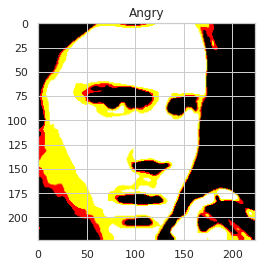

In [22]:
emotion_dict = {0: 'Angry', 1:'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6:'Neutral'}
import matplotlib.pyplot as plt
plt.imshow(feature[0,:,:,:])
plt.title(emotion_dict[np.argmax(lable[0])]);

In [23]:
import tensorflow as tf
vggface = VGGFace(model='resnet50', include_top=False, input_shape = (224,224,3))

vggface.trainable = False
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])


model = Sequential([ vggface,
                    Flatten(),
                    Dropout(0.25),
                    Dense(4096, activation='relu'),
                    Dropout(0.25),
                    Dense(1024, activation='relu'),
                    Dense(7, activation='softmax', name = 'classifer')])
#for i in range(101):
#            vggface.layers[i].trainable = False

model.summary()

94699520/94694792 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Functional (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 4096)              8392704   
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              4195328   
_______________________________________________________

In [24]:
BS = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 19

In [25]:
from keras.engine import Model
vgg_notop = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
last_layer = vgg_notop.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='relu', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)
# l=0
# for layer in vgg_notop.layers:
#     print(layer,"["+str(l)+"]")
#     l=l+1
    
batch_norm_indices = [2, 6, 9, 13, 14, 18, 21, 24, 28, 31, 34, 38, 41, 45, 46, 53, 56, 60, 63, 66, 70, 73, 76, 80, 83, 87, 88, 92, 95, 98, 102, 105, 108, 112, 115, 118, 122, 125, 128, 132, 135, 138, 142, 145, 149, 150, 154, 157, 160, 164, 167, 170]
for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        vgg_notop.layers[i].trainable = False
# print('vgg layer 2 is trainable: ' + str(vgg_notop.layers[2].trainable))
# print('vgg layer 3 is trainable: ' + str(vgg_notop.layers[3].trainable))

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(vgg_notop.input, out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_2[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

In [26]:
train_sequence = data_sequence(x_train,y_train,batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True)
val_sequence = data_sequence(x_val,y_val,batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True)
test_sequence  = data_sequence(x_test, y_test, batch_size=64,target_dim=(224,224),n_classes=7,shuffle=True)

In [27]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/emotion_model_resnet.h5')

In [28]:
import tensorflow as tf
y_pred = []
y_true = []
for x,y in test_sequence:
    probas=model.predict(x)
    y_hat=np.argmax(probas,axis=1)
    y_pred = y_pred + list(y_hat)
    y_true = y_true + list(np.argmax(y,axis=1))


In [29]:
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Sad", 5: "Surprised", 6: "Neutral"}


confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
confusion_matrix = np.around(confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis], decimals=2)

confusion_matrix = pd.DataFrame(confusion_matrix,
                                index = emotion_dict.values(), 
                                columns = emotion_dict.values())



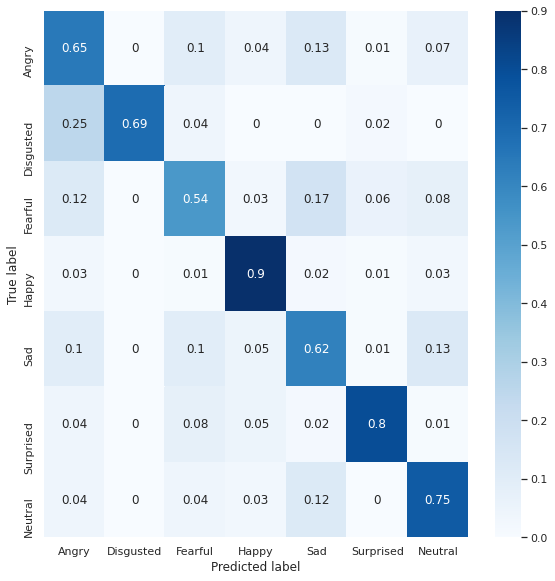

In [30]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred,target_names=list(emotion_dict.values())))

              precision    recall  f1-score   support

       Angry       0.61      0.65      0.63       490
   Disgusted       0.88      0.69      0.78        55
     Fearful       0.61      0.54      0.57       527
       Happy       0.89      0.90      0.89       879
         Sad       0.59      0.62      0.61       594
   Surprised       0.85      0.80      0.82       416
     Neutral       0.72      0.75      0.74       623

    accuracy                           0.73      3584
   macro avg       0.74      0.71      0.72      3584
weighted avg       0.73      0.73      0.73      3584



# Train only top layer

In [32]:
# and decreases it exponentially after that.
def scheduler(epoch, lr):
  if epoch % 5 ==0:
    return lr * 0.5
  else:
    return lr 

In [33]:

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [34]:
EPOCHS = 50
BS = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 170

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 197

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=6, min_lr=1e-5,verbose=1)
optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optim = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)

rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)
earlyStop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',patience=15
)


model.compile(optimizer = sgd, loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit_generator(generator = train_sequence,
                           validation_data = val_sequence,
                           epochs = 50, callbacks=[rlrop,earlyStop])

In [ ]:
model.evaluate(test_sequence)

56/56 [==============================] - 10s 172ms/step - loss: 0.8323 - accuracy: 0.7257


[0.8323405981063843, 0.7257254719734192]

# start fine tuning

In [ ]:
#could be done using vgcc.trainable=True but we must leave batch normalization layers to False
for layer in model.layers[0].layers:
    if 'bn' not in layer.name:
        layer.trainable = True

In [ ]:
import tensorflow as tf 
sgd=tf.keras.optimizers.SGD(
    learning_rate=1e-5, 
)
adam=tf.keras.optimizers.Adam(
    learning_rate=1e-5, 
)
model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=['accuracy'])
hist2 = model.fit_generator(generator = train_sequence,
                            validation_data = val_sequence,
                            epochs = 10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
397/448 [=========================>....] - ETA: 8s - loss: 0.1417 - accuracy: 0.9482

In [ ]:
for key in ['accuracy','val_accuracy','loss','val_loss']:
    hist.history[key] = hist.history[key] + hist2.history[key]

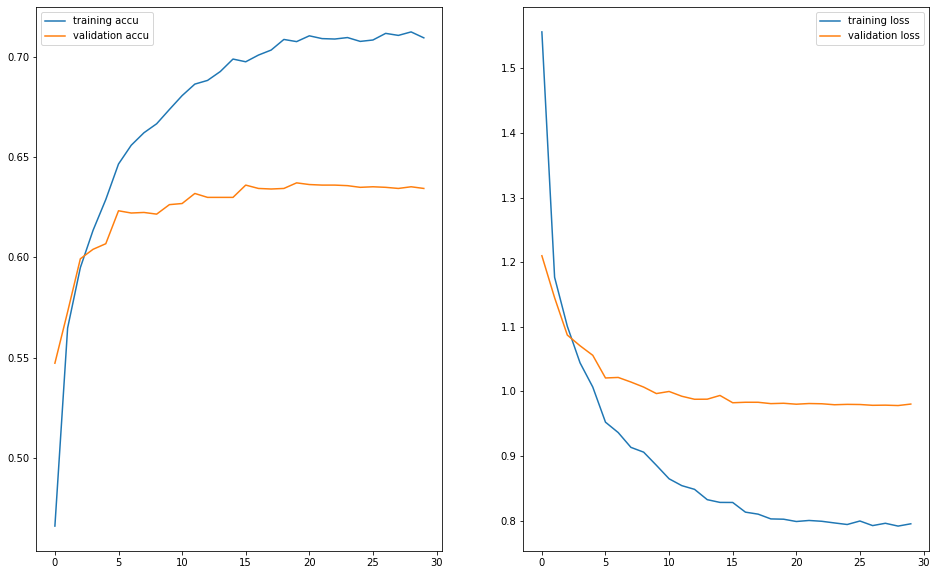

In [ ]:
#loaded_model = keras.models.load_model('/content/drive/MyDrive/emotion_model_inception.h5')
plt.figure(figsize=(16,10))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['training accu','validation accu'])
plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['training loss ','validation loss'])

In [ ]:
model.save('/content/drive/MyDrive/emotion_model_resnet.h5')